In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import log2csv

In [2]:
clock_rate_hz = 3.2e9

bw_bps = 200e9
link_delay_sec = 420 / clock_rate_hz
payload_size_bytes = 1024
mtu_bytes = 1088

# TODO: Calculate the time between a packet is transmitted
#       by the end host, and it arrives at the bottleneck
#       switch. TOPOLOGY SPECIFIC PARAMETER
time_to_switch_from_sender_sec = mtu_bytes * 8 / bw_bps + link_delay_sec
time_to_receiver_from_switch_sec = mtu_bytes * 8 / bw_bps + link_delay_sec

save_figs = False
save_folder = './'

In [3]:
data = {}
data['120KB'] = {}
data['63KB'] = {}
# Add protocols to be analyzed into the data
data['120KB']['LNIC'] = {
    'switchlog': "../../../software/local_firesim/logs/local_firesim_2021_04_06-LNIC-Buff110p/switchlog" }
data['63KB']['LNIC'] = {
    'switchlog': "../../../software/local_firesim/logs/recent/switchlog" }

buff_sizes = list(data.keys())
protocol_names = list(data[buff_sizes[0]].keys())

In [4]:
def client_ip_to_id(client_ip):
    return int(client_ip.split('.')[-1]) - 3 

In [5]:
for buff_size in data.keys(): 
    for proto in data[buff_size].keys(): 
        stats = log2csv.parse_switchlog(data[buff_size][proto]['switchlog'])
        qsize, _, _, _, pkt_trace = stats

        qsize_df = pd.DataFrame(qsize, dtype=float)
        qsize_df = qsize_df[qsize_df.port == 0] # switch port only
        qsize_df['time_sec'] = qsize_df.time / clock_rate_hz
        data[buff_size][proto]['qsize_df'] = qsize_df[['time','time_sec','tot_bytes']]
        print("Max Queue Occupancy for {} ({}): {} Bytes".format(proto, buff_size, 
                                                           qsize_df.tot_bytes.max()))

        pkt_trace_df = pd.DataFrame(pkt_trace, dtype=float)
        trace_proto = pd.unique(pkt_trace_df.proto)
        assert len(trace_proto) == 1, "ERROR: Trace has packets for multiple protocols!"
        trace_proto = trace_proto[0]
        assert trace_proto == proto, "ERROR: Trace belogs to a different protocol!"
        pkt_trace_df = pkt_trace_df[pkt_trace_df.flags == 'DATA'] # data pkts only
        pkt_trace_df['msg_len_pkts'] = pkt_trace_df.msg_len_bytes / payload_size_bytes
        pkt_trace_df['time_sec'] = pkt_trace_df.time / clock_rate_hz
        data[buff_size][proto]['pkt_trace_df'] = pkt_trace_df

Max Queue Occupancy for LNIC (120KB): 119680.0 Bytes
Max Queue Occupancy for LNIC (63KB): 64472.0 Bytes


# Slow Down Analysis

In [6]:
for buff_size in data.keys(): 
    for proto in data[buff_size].keys(): 
        data[buff_size][proto]['msgs'] = {'proto': [], 'buff_size': [],
                                          'msg_idx': [],
                                          'msg_size_pkts':[],
                                          'start_time_sec': [],
                                          'fin_time_sec':[],
                                          'mct': [], 'ict': [],
                                          'slowdown': []}
        
        qsize_df = data[buff_size][proto]['qsize_df']
        pkt_trace_df = data[buff_size][proto]['pkt_trace_df']
        for (src_ip, src_port), msg_df in pkt_trace_df.groupby(['src_ip','src_context']):
            
            data[buff_size][proto]['msgs']['proto'].append(proto)
            data[buff_size][proto]['msgs']['buff_size'].append(buff_size)
            
            msg_idx = client_ip_to_id(src_ip)
            data[buff_size][proto]['msgs']['msg_idx'].append(int(msg_idx))
            
            msg_len_pkts = pd.unique(msg_df.msg_len_pkts)
#             assert len(msg_len_pkts) == 1
            msg_len_pkts = int(msg_len_pkts[0])
            data[buff_size][proto]['msgs']['msg_size_pkts'].append(msg_len_pkts)
            
            start_time = msg_df.time_sec.min() - time_to_switch_from_sender_sec
            data[buff_size][proto]['msgs']['start_time_sec'].append(start_time)
            
            pkt_bitmap = [False] * msg_len_pkts
            fin_time = None
            for _, pkt in msg_df.iterrows():
                pkt_bitmap[int(pkt['pkt_offset'])] = True
                if (all(pkt_bitmap)):
                    fin_time = pkt['time_sec'] \
                              + qsize_df[qsize_df.time_sec==pkt['time_sec']].tot_bytes.max() * 8 / bw_bps \
                              + time_to_receiver_from_switch_sec
                    break
            fin_time = start_time if (not fin_time) else fin_time
            data[buff_size][proto]['msgs']['fin_time_sec'].append(fin_time)
            
            mct = fin_time - start_time
            data[buff_size][proto]['msgs']['mct'].append(mct)
            
            ict = (msg_len_pkts-1) * mtu_bytes * 8 / bw_bps \
                 + time_to_switch_from_sender_sec \
                 + time_to_receiver_from_switch_sec
            data[buff_size][proto]['msgs']['ict'].append(ict)
            
            data[buff_size][proto]['msgs']['slowdown'].append(mct/ict)
            
        data[buff_size][proto]['msgs'] =  pd.DataFrame(data[buff_size][proto]['msgs'],
                                                       dtype=float)
        
all_msgs_df = None
for buff_size in data.keys(): 
    for proto in data[buff_size].keys():
        if (all_msgs_df is None):
            all_msgs_df = data[buff_size][proto]['msgs']
        else:
            all_msgs_df = pd.concat([all_msgs_df, data[buff_size][proto]['msgs']],
                                    ignore_index=True)

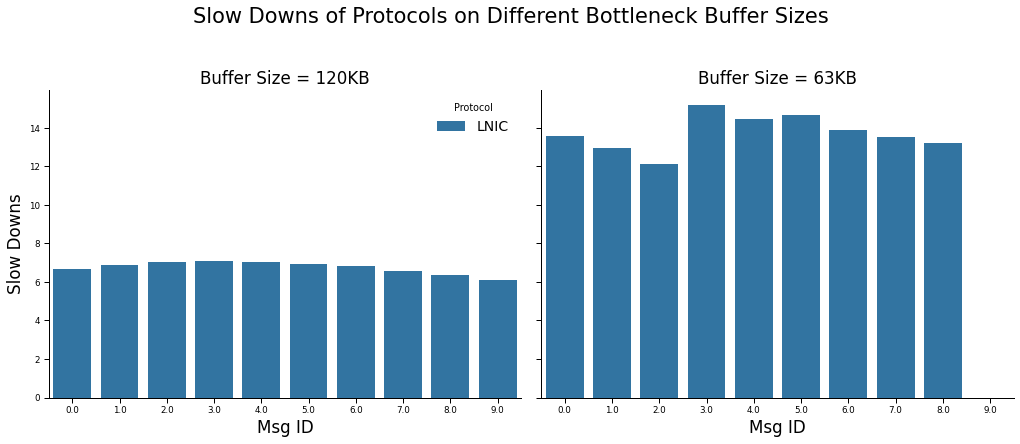

In [7]:
fontsize = 14
sns.set_context("paper", 
                rc={"font.size":fontsize,
                    "axes.titlesize":fontsize*1.5,
                    "axes.labelsize":fontsize*1.2}) 

g = sns.catplot(data = all_msgs_df, x = "msg_idx", y = "slowdown",
                hue = "proto", hue_order=protocol_names, 
                col = "buff_size", kind = "bar", 
                legend=True, legend_out=False,
                height=6, aspect=1.2)
g.set_axis_labels("Msg ID", "Slow Downs")
g.set_titles('Buffer Size = {col_name}')
g.add_legend(title='Protocol', label_order=protocol_names,
             fontsize=fontsize, frameon=False)
st = plt.suptitle('Slow Downs of Protocols on Different Bottleneck Buffer Sizes',
                  y=1.03, fontsize=fontsize*1.5)
plt.tight_layout()
if (save_figs):
    plt.savefig(os.path.join(save_folder, 'LnicProtoEval-MsgSlowDowns.png'), 
                bbox_extra_artists=[st], bbox_inches='tight')
plt.show()

# Queue Size Analysis

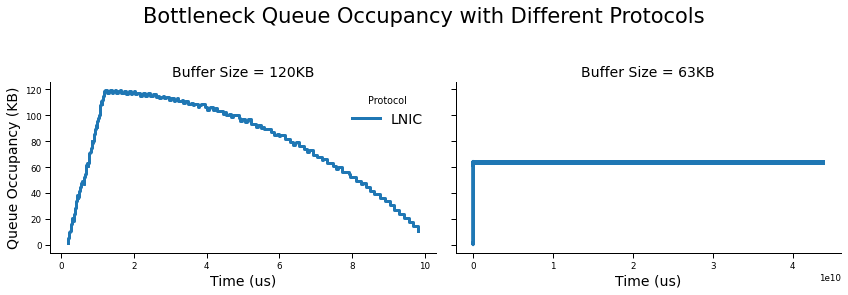

In [8]:
fontsize = 14
fig, ax = plt.subplots(1,len(buff_sizes),
                       figsize=(12,4), sharey=True)
if (len(buff_sizes)==1):
    ax = [ax]
i=1
for buff_size in data.keys(): 
    plt.sca(ax[i-1])
    for proto, proto_data in data[buff_size].items():
        qsize_df = proto_data['qsize_df']
        qsize_df = qsize_df[qsize_df.time_sec != 0]
        trc_start_time = qsize_df.time_sec.min() - time_to_switch_from_sender_sec
        plt.step((qsize_df.time_sec - trc_start_time) * 1e6,
                 qsize_df.tot_bytes / 1e3,
                 label = proto, linewidth=3., where='post',
                 c='C'+str(protocol_names.index(proto)))
            
        plt.xlabel('Time (us)',fontsize=fontsize)
        plt.gca().spines["right"].set_visible(False)
        plt.gca().spines["top"].set_visible(False)
        plt.title('Buffer Size = {}'.format(buff_size), fontsize=fontsize)
    i += 1
    
ax[0].set_ylabel('Queue Occupancy (KB)',fontsize=fontsize)

handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(protocol) for protocol in protocol_names]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           title='Protocol', fontsize=fontsize, 
           frameon=False, markerscale=2.0)
# plt.grid()
st = plt.suptitle('Bottleneck Queue Occupancy with Different Protocols',
                  y=1.03, fontsize=fontsize*1.5)
plt.tight_layout()
if (save_figs):
    plt.savefig(os.path.join(save_folder, 'LnicProtoEval-QueueOccupancy.png'), 
                bbox_extra_artists=[st], bbox_inches='tight')
plt.show()